In [80]:
import random
import chess
import pgn
import sys
import numpy as np
from keras import layers
from keras import models
import copy
from keras import utils
from random import randrange

The paper I'm loosely replicating

https://www.cs.tau.ac.il/~wolf/papers/deepchess.pdf

In [81]:
random.seed(1)

Define useful functions

In [82]:
def shorten_string(s):
    s = s[:s.rfind(" ")]
    return s

def fen_to_bit(f):
    pieces = {
        'p': 1,
        'P': 7,
        'n': 2,
        'N': 8,
        'b': 3,
        'B': 9,
        'r': 4,
        'R': 10,
        'q': 5,
        'Q': 11,
        'k': 6,
        'K': 12
            }
    
    f = shorten_string(f)

    for i in range(2):
        f = shorten_string(f)

    piece_squares = np.zeros(64)
    ranks = shorten_string(shorten_string(f)).split('/')
    
    for rank_count,rank in enumerate(ranks):
        #print(rank_count)
        file_count = 0
        for item in rank:

            if item.isnumeric():
                file_count += int(item)
            else:
                piece_squares[(file_count + (8 * (rank_count)))] = pieces[item]
                file_count += 1
    
    all_bits = np.zeros(64*12)
    for c,square in enumerate(piece_squares):
        if square > 0:
            all_bits[int((max((square-1),0) * 64) + c)] = 1
            
    to_move = shorten_string(f)[-1]
    if to_move == 'w':
        all_bits = np.append(all_bits,1)
    else:
        all_bits = np.append(all_bits,0)
    
    castle = f[-4:]
    for letter in 'KQkq':
        if letter in castle:
            all_bits = np.append(all_bits,1)
        else:
            all_bits = np.append(all_bits,0)
    return(all_bits)

## Chess stuff

In [ ]:
!pwd

In [ ]:
import csv

This process can be performed using the python script in the directory as well for faster results.

In [ ]:
print('loading data...')
white_positions = []
with open('random_white_positions_3956350.csv') as csvfile:
    r = csv.reader(csvfile, delimiter=',')
    for row in r:
        white_positions.append(row)

black_positions = []
with open('random_black_positions_2928400.csv') as csvfile:
    r = csv.reader(csvfile, delimiter=',')
    for row in r:
        black_positions.append(row)


print('setting up bits holders')
#num_positions = 1000000
white_bits = np.zeros((len(white_positions),773))
black_bits = np.zeros((len(black_positions),773))

In [ ]:
white_positions[0][:5]

Set number of positions to use

In [ ]:
num_positions = 10000 # 10000 is for example, recommended to use many more

This section of code converts the fen positions to bits. In addition, it alternates placing white wins and black wins in either bits1 or bits2 with corresponding labels in y, though later I just use a generator that pulls specific y values at that point.

In [ ]:
bits1 = np.zeros((num_positions,773))
bits2 = np.zeros((num_positions,773))
count = 0
y = np.zeros((num_positions,2))
while count < num_positions:
    if count%10000 == 0:
        print(count)
    white_position = white_positions[randrange(0,len(white_positions)-1)]
    board = chess.Board()
    for move in white_position:
        board.push_san(move)
    
    white_bits = fen_to_bit(board.fen())

    black_position = black_positions[randrange(0,len(black_positions)-1)]
    board = chess.Board()
    for move in black_position:
        board.push_san(move)
    
    black_bits = fen_to_bit(board.fen())
    
    order = randrange(0,2)

    if order == 0:
        bits1[count,:] = white_bits
        bits2[count,:] = black_bits
        y[count,:] = [1,0]
    if order == 1:
        bits1[count,:] = black_bits
        bits2[count,:] = white_bits
        y[count,:] = [0,1]
    count+=1

Start here if preprocessing was done outisde of the notebook

In [83]:
from sklearn.model_selection import train_test_split

In [84]:
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D,Activation, Dropout
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import Adam
from skimage.io import imshow
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn.utils import shuffle
import tensorflow as tf

In [85]:
tf.compat.v1.enable_eager_execution(
    config=None, device_policy=None, execution_mode=None
)

In [86]:
# import importlib
# importlib.reload(keras)

In [ ]:
bits_white = np.load('./bits_white_3956350.npy')
bits_black = np.load('./bits_black_2928400.npy')

In [ ]:
l = 100000

split into train and validation

In [ ]:
bits_white_train = bits_white[round(l):,:]
bits_black_train = bits_black[round(l):,:]

bits_white_val = bits_white[:round(l),:]
bits_black_val = bits_black[:round(l),:]

In [ ]:
# bits_white = shuffle(bits_white,random_state=1)
# bits_black = shuffle(bits_black,random_state=1)

In [ ]:
print(len(bits_white_train))
print(len(bits_black_train))
print(len(bits_white_val))
print(len(bits_black_val))

In [ ]:
# white_win_left = []
# white_win_right = []
# for num,pair in enumerate(y_train[:]):
#     #print(pair[0])
#     if pair[0] == 1:
#         #print('here')
#         white_win_left.append(num)
#         #white_win_right.append(0)
#     else:
#         #white_win_left.append(0)
#         white_win_right.append(num)

# Autoencoder

In [87]:
import keras

I pulled this DenseTied class from elsewhere to use here

In [88]:
class DenseTied(keras.layers.Layer):
    def __init__(self, units,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 tied_to=None,
                 **kwargs):
        self.tied_to = tied_to
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super().__init__(**kwargs)
        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)
        self.activity_regularizer = keras.regularizers.get(activity_regularizer)
        self.kernel_constraint = keras.constraints.get(kernel_constraint)
        self.bias_constraint = keras.constraints.get(bias_constraint)
        self.input_spec = keras.layers.InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        if self.tied_to is not None:
            self.kernel = K.transpose(self.tied_to.kernel)
            self._non_trainable_weights.append(self.kernel)
        else:
            self.kernel = self.add_weight(shape=(input_dim, self.units),
                                          initializer=self.kernel_initializer,
                                          name='kernel',
                                          regularizer=self.kernel_regularizer,
                                          constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        self.input_spec = keras.layers.InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) >= 2
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)

    def call(self, inputs, **kwargs):
        output = K.dot(inputs, self.kernel)
        if self.use_bias:
            output = K.bias_add(output, self.bias, data_format='channels_last')
        if self.activation is not None:
            output = self.activation(output)
        return output

In [89]:
from keras.layers import Dense, Input
from keras.models import Model
import keras
import numpy as np
import gc

Encoder

In [90]:
input_layer = Input(shape=(773,))
hidden_1 = Dense(600, activation='relu')(input_layer)
hidden_2 = Dense(400, activation='relu')(hidden_1)
hidden_3 = Dense(200, activation='relu')(hidden_2)
code = Dense(100, activation='relu')(hidden_3)

encoder = Model(input_layer, code, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 773)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 600)               464400    
_________________________________________________________________
dense_10 (Dense)             (None, 400)               240400    
_________________________________________________________________
dense_11 (Dense)             (None, 200)               80200     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               20100     
Total params: 805,100
Trainable params: 805,100
Non-trainable params: 0
_________________________________________________________________


In [91]:
from keras import backend as K

Decoder

In [92]:
code_input = Input(shape=(100,))
hidden_1 = DenseTied(200, activation='relu', tied_to=encoder.layers[4])(code_input)
hidden_2 = DenseTied(400, activation='relu', tied_to=encoder.layers[3])(hidden_1)
hidden_3 = DenseTied(600, activation='relu', tied_to=encoder.layers[2])(hidden_2)
output_layer = DenseTied(773, activation='sigmoid', tied_to=encoder.layers[1])(hidden_3)

decoder = Model(code_input, output_layer, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_tied_5 (DenseTied)     (None, 200)               40300     
_________________________________________________________________
dense_tied_6 (DenseTied)     (None, 400)               160600    
_________________________________________________________________
dense_tied_7 (DenseTied)     (None, 600)               481000    
_________________________________________________________________
dense_tied_8 (DenseTied)     (None, 773)               928973    
Total params: 1,610,873
Trainable params: 807,073
Non-trainable params: 803,800
_________________________________________________________________


Combine

In [93]:
input_layer = Input(shape=(773,))
#         if load:
#             self.encoder = keras.models.load_model('./Pos2Vec/encoder_v1/encoder_epoch66')
        #else:

ec_out = encoder(input_layer)
dc_out = decoder(ec_out)

autoencoder = Model(input_layer, dc_out, name='autoencoder')
model = autoencoder
model.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 773)               0         
_________________________________________________________________
encoder (Model)              (None, 100)               805100    
_________________________________________________________________
decoder (Model)              (None, 773)               1610873   
Total params: 1,610,873
Trainable params: 807,073
Non-trainable params: 803,800
_________________________________________________________________


In [94]:
from keras import losses
from tensorflow.keras import optimizers

Define learning rate scheduler

In [95]:
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=200,
    decay_rate=0.98)
opt = optimizers.SGD(learning_rate=lr_schedule)

Define loss and compile model

In [96]:
model.compile(optimizer=opt, loss='binary_crossentropy')

In [ ]:
positions_val = np.concatenate((bits_white_val,bits_black_val))

In [ ]:
# for i in range(0,200):
#     print(i)
#     l1 = np.random.randint(low=0,high=len(bits_white_train)-1,size=100000)
#     p1 = bits_white_train[l1,:]
    
#     l2 = np.random.randint(low=0,high=len(bits_black_train)-1,size=100000)
#     p2 = bits_black_train[l2,:]
    
#     print('concatenating...')
#     train = np.concatenate((p1,p2))
    
#     model.fit(train,train, validation_data=(positions_val, positions_val), epochs = 1, batch_size=256)
    
#     #encoder.save(f'encoder_epoch_{i}') #save at certain points if desired
    
#     gc.collect()
    


In [ ]:
l1 = np.random.randint(low=0,high=len(bits_white_train)-1,size=1000000)
p1 = bits_white_train[l1,:]

In [ ]:
l2 = np.random.randint(low=0,high=len(bits_black_train)-1,size=1000000)
p2 = bits_black_train[l2,:]

In [ ]:
# positions = np.concatenate(bits_white_train,bits_black_train)
# positions_val = np.concatenate(bits_white_val,bits_black_val)

In [ ]:
train = np.concatenate((p1,p2))

This will take some time...

In [ ]:
model.fit(train,train, validation_data=(positions_val, positions_val), epochs = 200, batch_size=256)

In [ ]:
# encoder.save('./encoder_epoch' + str(71))
# decoder.save('./decoder_epoch' + str(71))
# model.save('./autoencoder_epoch' + str(71))


Load the encoder and set up siamese configuration

In [97]:
enc = models.load_model('encoder_epoch_45')
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.005,
    decay_steps=200,
    decay_rate=0.98)
opt = optimizers.SGD(learning_rate=lr_schedule)
enc.compile(optimizer=opt,loss='binary_crossentropy')

In [98]:
input_shape = [773]
inputt = Input(input_shape)
left_input = Input(input_shape)
right_input = Input(input_shape)

In [99]:
encoded_left = enc(left_input)
encoded_right = enc(right_input)

In [100]:
combo = layers.concatenate([encoded_left, encoded_right])

In [101]:
distillation = layers.Dense(400)(combo)
distillation = layers.Dense(200)(distillation)
distillation = layers.Dense(100)(distillation)

In [102]:
outputs = layers.Dense(2, activation = 'softmax')(distillation)

In [103]:
model = Model(inputs=[left_input,right_input], outputs=outputs, name='deep_chess')

In [104]:
model.summary()

Model: "deep_chess"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 773)          0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 773)          0                                            
__________________________________________________________________________________________________
encoder (Model)                 (None, 100)          805100      input_11[0][0]                   
                                                                 input_12[0][0]                   
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 200)          0           encoder[1][0]           

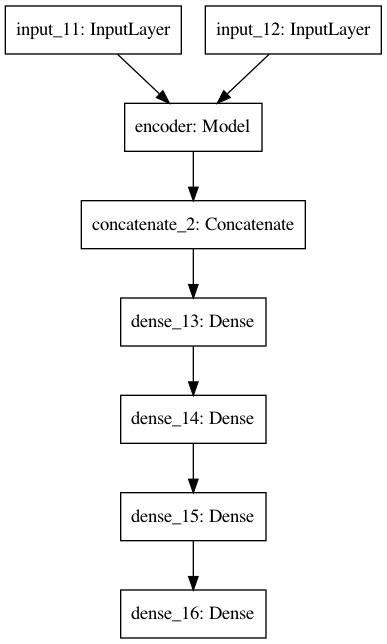

In [105]:
utils.plot_model(model)

In [106]:
from keras import losses
from keras import optimizers

In [107]:
from tensorflow.keras import optimizers

In [108]:
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.99)
opt = optimizers.SGD(learning_rate=lr_schedule)

In [117]:
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])

In [110]:
batch_size = 1000

In [111]:
import keras.callbacks as cb

In [112]:
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the folder name.
    cb.ModelCheckpoint(
        filepath='./model_with_ae_epoch_{epoch:02d}')]


In [ ]:
model.fit(generator(bits_white_train, bits_black_train, batch_size), epochs=1000,initial_epoch=396,steps_per_epoch=1000,callbacks=callbacks)


In [ ]:
#model.save('new_latest_e_397_acc_869')

In [ ]:
from keras import models

In [113]:
model = models.load_model('model_with_ae_epoch_396')

/opt/anaconda3/lib/python3.7/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [118]:
lr_schedule = optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.99)
opt = optimizers.SGD(learning_rate=lr_schedule)

In [119]:
model.compile(optimizer=opt, loss='binary_crossentropy',metrics=['accuracy'])

Evaluate on validation set

In [120]:
y_val1 = np.zeros((len(bits_black_val),2))
for i in range(0,len(bits_black_val)):
    random_order = random.choice([0,1])
    y_val1[i,:] = [1,0]

In [121]:
y_val2 = np.zeros((len(bits_black_val),2))
for i in range(0,len(bits_black_val)):
    random_order = random.choice([0,1])
    y_val2[i,:] = [0,1]

In [122]:
loss, acc = model.evaluate([bits_black_val, bits_white_val], y_val2)
print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))

100000/100000 [==============================] - 19s 194us/step

Testing loss: 0.316986257455349, acc: 0.8476700186729431



The best model I've achieved so far has around 0.85 accuracy in identifying winning positions

These are a few test cases for the model. One where white is up a piece or opening positions e.g.

In [123]:
white_up_piece = fen_to_bit('rnbqk1nr/ppp2ppp/8/3P4/3P4/N3BN2/PPP2PPP/R2QKB1R b KQkq - 0 6')
normal = fen_to_bit('r1bq1rk1/ppp1bppp/2np1n2/1B2p3/4P3/2PP1N2/PP3PPP/RNBQ1RK1 w - - 1 7')

In [124]:
model.predict([normal.reshape(1,-1),white_up_piece.reshape(1,-1)])

array([[0.41942507, 0.580575  ]], dtype=float32)

In [125]:
model.predict([white_up_piece.reshape(1,-1),normal.reshape(1,-1)])

array([[0.5804533 , 0.41954672]], dtype=float32)

My model correctly evaluates that white is more likely to win in a piece-up position.

In [126]:
e4 = fen_to_bit('rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1')
a4 = fen_to_bit('rnbqkbnr/pppppppp/8/8/P7/8/1PPPPPPP/RNBQKBNR b KQkq - 0 1')

In [127]:
model.predict([e4.reshape(1,-1),a4.reshape(1,-1)])

array([[0.55942124, 0.4405788 ]], dtype=float32)

In [128]:
model.predict([a4.reshape(1,-1),e4.reshape(1,-1)])

array([[0.43890917, 0.5610909 ]], dtype=float32)

My model prefers e4 over a4 as an opening move

In [129]:
black_gives_up_pawn = fen_to_bit('rnbqkbnr/1ppp1ppp/8/p3p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 0 3')
black_protects_pawn = fen_to_bit('r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq - 2 3')

In [130]:
model.predict([black_protects_pawn.reshape(1,-1),black_gives_up_pawn.reshape(1,-1)])

array([[0.49440438, 0.5055956 ]], dtype=float32)

In [131]:
model.predict([black_gives_up_pawn.reshape(1,-1),black_protects_pawn.reshape(1,-1)])

array([[0.50330025, 0.49669978]], dtype=float32)

My model evaluates these about evenly.

This sets up the minimax algorithm for playing a game. It uses crushing positions as "best/worst case" scenarios for comparison when necessary.

In [140]:
white_crushing = chess.Board('4k3/8/8/PPPPPPPP/1RBQNB2/2NKR3/8/8 b - - 20 45')
black_crushing = chess.Board('8/3bk3/1rnbqnr1/pppppppp/8/8/4K3/8 w - - 18 37')
def minimax(position, depth, alpha, beta, maximizing_player):
    if depth == 0:
        return position 
    else:
        if maximizing_player:
            if alpha == None:
                alpha = black_crushing
            first = True
            for move in chess.LegalMoveGenerator(position):
                #print(f'white depth: {depth}, move: {move}')
                position_copy = copy.copy(position)
                position_copy.push_uci(move.uci())
                
#                 if first:
#                     alpha = minimax(position_copy, depth-1, alpha, beta, False)
#                     first = False
#                 else:
                next_position = minimax(position_copy, depth-1, alpha, beta, False)
                #print('\nevaluating this:\n',next_position.unicode(),'\nvs this:\n',alpha.unicode())
                #print(f'\naka this: {next_position.fen()}\n')
                #print(f'\nvs this: {alpha.fen()}')
                result = evaluate_pair(next_position, alpha, is_fen=False)[0][0]
                if result > .5:
                    alpha = next_position
                    #print('\nnew alpha:\n')
                    #print(alpha.unicode())
#                     if beta:
#                         if evaluate_pair(next_position.fen(), beta.fen(), is_fen=True)[0][0] > .5:
#                             print(f'new position is better than beta. Pruning...\n')
#                             break
            return alpha
        else:
            if beta == None:
                beta = white_crushing
            first = True
            for move in chess.LegalMoveGenerator(position):
                #print(f'black depth: {depth}, move: {move}')
                position_copy = copy.copy(position)
                position_copy.push_uci(move.uci())
                
#                 if first:
#                     beta = minimax(position_copy, depth-1, alpha, beta, True)
#                     first = False
                #else:
                next_position = minimax(position_copy, depth-1, alpha, beta, True)
                #print('\nevaluating this:\n',next_position.unicode(),'\nvs this:\n',beta.unicode())
                #print(f'\naka this: {next_position.fen()}\n')
                #print(f'\nvs this: {beta.fen()}')
                result = evaluate_pair(next_position, beta, is_fen=False)[0][0]
                if result < .5:
                    beta = next_position
                    #print('\nnew beta:\n')
                    #print(beta.unicode())
#                    if alpha:
#                         if evaluate_pair(next_position.fen(), alpha.fen(), is_fen=True)[0][0] < .5:
#                             print(f'new position is worse than alpha. Pruning...\n')
#                             break
            return beta
        
                    
                    
            

Here defining the play function

In [141]:
def play():
    print('Do you want to play as white or black?\n')
    player = input()
    if player not in ['white','black']:
        print('\ntype white or black')
    print('Enter desired bot depth:\n')
    depth = int(input())
        
    if player == 'white':
        board = chess.Board()
        move_count = 0
        ongoing = True
        while ongoing == True:
            #player move
            p_move = get_player_move(board)
            board.push_san(p_move)
            
            c_move = get_computer_move(board,depth,is_white=False)
            
            board.push_uci(c_move.uci())
            
            print(board.unicode())
            
            if board.is_game_over == True:
                print('game over')
                ongoing=False
                
    if player == 'black':
        board = chess.Board()
        move_count = 0
        ongoing = True
        while ongoing == True:
            
            #comp move
            c_move = get_computer_move(board,depth,is_white=True)
            
            board.push_uci(c_move.uci())
            
            print(board.unicode())
            
            #player move
            p_move = get_player_move(board)
            board.push_san(p_move)
            
            if board.is_game_over == True:
                print('game over')
                ongoing=False
            
            
            
        

Depth of 3 is pretty slow, so I assume I don't have a well optimized algorithm or my model needs to be simplified to be practically useful.

My model tends to advance pawns recklessly and likes the sicilian vs e4

In [143]:
play()

Do you want to play as white or black?

white
Enter desired bot depth:

2
Enter your move: 

e4
♜ ♞ ♝ ♛ ♚ ♝ ♞ ♜
♟ ♟ · ♟ ♟ ♟ ♟ ♟
· · · · · · · ·
· · ♟ · · · · ·
· · · · ♙ · · ·
· · · · · · · ·
♙ ♙ ♙ ♙ · ♙ ♙ ♙
♖ ♘ ♗ ♕ ♔ ♗ ♘ ♖
Enter your move: 

Bc4
♜ ♞ ♝ ♛ ♚ ♝ ♞ ♜
♟ ♟ · · ♟ ♟ ♟ ♟
· · · · · · · ·
· · ♟ ♟ · · · ·
· · ♗ · ♙ · · ·
· · · · · · · ·
♙ ♙ ♙ ♙ · ♙ ♙ ♙
♖ ♘ ♗ ♕ ♔ · ♘ ♖
Enter your move: 

Bxd4
Illegal move, please try again
Enter your move: 

Bxd5
♜ ♞ · ♛ ♚ ♝ ♞ ♜
♟ ♟ · · ♟ ♟ ♟ ♟
· · · · · · · ·
· · ♟ ♗ · · · ·
· · · · ♙ · ♝ ·
· · · · · · · ·
♙ ♙ ♙ ♙ · ♙ ♙ ♙
♖ ♘ ♗ ♕ ♔ · ♘ ♖
Enter your move: 

Qxf4
Illegal move, please try again
Enter your move: 

Qxg4
♜ ♞ · ♛ ♚ ♝ · ♜
♟ ♟ · · ♟ ♟ ♟ ♟
· · · · · ♞ · ·
· · ♟ ♗ · · · ·
· · · · ♙ · ♕ ·
· · · · · · · ·
♙ ♙ ♙ ♙ · ♙ ♙ ♙
♖ ♘ ♗ · ♔ · ♘ ♖
Enter your move: 

Qf3
♜ ♞ · ♛ ♚ ♝ · ♜
♟ ♟ · · ♟ ♟ ♟ ♟
· · · · · · · ·
· · ♟ ♞ · · · ·
· · · · ♙ · · ·
· · · · · ♕ · ·
♙ ♙ ♙ ♙ · ♙ ♙ ♙
♖ ♘ ♗ · ♔ · ♘ ♖
Enter your move: 

exd5
♜ ♞ · ♛ ♚ ♝ · ♜
♟ ♟ · · · ♟ ♟ ♟
· · 

IndexError: list index out of range

Other needed functions

In [134]:
def evaluate_pair(pos1,pos2,is_fen):
    if is_fen == False:
        bits1 = fen_to_bit(pos1.fen()).reshape(1,-1)
        bits2 = fen_to_bit(pos2.fen()).reshape(1,-1)
    else:
        bits1 = fen_to_bit(pos1).reshape(1,-1)
        bits2 = fen_to_bit(pos2).reshape(1,-1)
    return model.predict([bits1,bits2])

In [135]:
def get_player_move(board):
    cop = board.copy()
    while True:
        try:
            print("Enter your move: \n")
            move = input()
            cop.push_san(move)
            break
        except ValueError:
            print("Illegal move, please try again")

    return move

In [136]:
def get_computer_move(board,depth,is_white):
    best_position = minimax(board, depth=depth, alpha=None, beta=None, maximizing_player=is_white)
    
    original_num_moves = len(board.move_stack)
    new_num_moves = len(best_position.move_stack)
    diff = new_num_moves - original_num_moves

    best_move = best_position.move_stack[-(diff)]
    return(best_move)

___

Below you'll find old versions of code or examples I was learning from, not particularly structured or nice to look at.

___

___

___

## Old pre-processing code creates and saves x and y

In [ ]:
print('parsing games')
parsed_games = []
for num in range(len(m)):
    if num%100000 == 0:
        print(num)
    if num%2 == 1:
        unparsed_game = m[num].replace('\n',' ')
        new_game = []
        for entry in unparsed_game.split(' '):
            if entry[-1]!='.':
                new_game.append(entry)
        parsed_games.append(new_game)

In [ ]:
games = parsed_games.copy()

In [ ]:
no_draws = []
for game in games:
    if game[-1] != '1/2-1/2':
        no_draws.append(game)

In [ ]:
len(no_draws)

In [ ]:
white_wins = []
black_wins = []
for game in no_draws:
    if len(game) < 10:
        print('short game')
    if game[-1] == '1-0':
        white_wins.append(game[:-1])
    if game[-1] == '0-1':
        black_wins.append(game[:-1])

In [ ]:
#select 10 random positions per game
black_positions = []
white_positions = []
for game in white_wins:
    num=0
    #select 10 random positions:
    while num <10:
        potential_position = game[0:np.random.randint(5,len(game))]
        #print(potential_position)
        if 'x' in potential_position[-1]:
            continue
        else:
            white_positions.append(potential_position)
            #print('good position',potential_position)
            num+=1
for game in black_wins:
    print('black games')
    num=0
    #select 10 random positions:
    while num <10:
        potential_position = game[0:np.random.randint(5,len(game))]
        #print(potential_position)
        if 'x' in potential_position[-1]:
            continue
        else:
            black_positions.append(potential_position)
            #print('good position',potential_position)
            num+=1
        

In [ ]:
print(len(white_wins))
len(white_positions)

In [ ]:
board = chess.Board()

In [ ]:
position = white_positions[0]

In [ ]:
for move in position:
    board.push_san(move)

In [ ]:
move

In [ ]:
fen = board.fen()

In [ ]:
len(white_positions)

In [ ]:
from random import randrange

In [ ]:
num_positions = 50000
bits1 = np.zeros((num_positions,773))
bits2 = np.zeros((num_positions,773))
count = 0
y = np.zeros((num_positions,2))
while count < num_positions:
    white_position = white_positions[randrange(0,len(white_positions)-1)]
    board = chess.Board()
    for move in white_position:
        board.push_san(move)
    
    white_bits = fen_to_bit(board.fen())

    black_position = black_positions[randrange(0,len(black_positions)-1)]
    board = chess.Board()
    for move in black_position:
        board.push_san(move)
    
    black_bits = fen_to_bit(board.fen())
    
    order = randrange(0,2)
    
#     if order == 0:
#         all_bits.append(np.concatenate((white_bits.reshape(-1,1),black_bits.reshape(-1,1)),axis=1))
#         y.append(np.array([1,0]))
#     if order == 1:
#         all_bits.append(np.concatenate((black_bits.reshape(-1,1),white_bits.reshape(-1,1)),axis=1))
#         y.append(np.array([0,1]))

#instantiate these above with zeros and then fill
    if order == 0:
        bits1[count,:] = white_bits
        bits2[count,:] = black_bits
        y[count,:] = [1,0]
    if order == 1:
        bits1[count,:] = black_bits
        bits2[count,:] = white_bits
        y[count,:] = [0,1]
    count+=1
    #print(count)

In [ ]:
# np.save('bits1',bits1)
# np.save('bits2',bits2)
# np.save('y',y)

___

___

# some other deep learning code I was referencing

In [ ]:
############### other code
class AutoEncoder:
    def __init__(self):
        self.positions = []
        self.positions_val = []
        self.model = None
        self.encoder = None
        self.decoder = None

    def __encoder(self):
        input_layer = Input(shape=(773,))
        hidden_1 = Dense(600, activation='relu')(input_layer)
        hidden_2 = Dense(400, activation='relu')(hidden_1)
        hidden_3 = Dense(200, activation='relu')(hidden_2)
        code = Dense(100, activation='relu')(hidden_3)

        encoder = Model(input_layer, code, name='encoder')
        encoder.summary()
        self.encoder = encoder
        return encoder

    def __decoder(self):
        code_input = Input(shape=(100,))
        hidden_1 = DenseTied(200, activation='relu', tied_to=self.encoder.layers[4])(code_input)
        hidden_2 = DenseTied(400, activation='relu', tied_to=self.encoder.layers[3])(hidden_1)
        hidden_3 = DenseTied(600, activation='relu', tied_to=self.encoder.layers[2])(hidden_2)
        output_layer = DenseTied(773, activation='sigmoid', tied_to=self.encoder.layers[1])(hidden_3)

        decoder = Model(code_input, output_layer, name='decoder')
        decoder.summary()
        self.decoder = decoder
        return decoder

    def encoder_decoder(self, load=0):
        input_layer = Input(shape=(773,))
#         if load:
#             self.encoder = keras.models.load_model('./Pos2Vec/encoder_v1/encoder_epoch66')
        #else:
        self.__encoder()
        self.__decoder()

        ec_out = self.encoder(input_layer)
        dc_out = self.decoder(ec_out)

        autoencoder = Model(input_layer, dc_out, name='autoencoder')
        self.model = autoencoder
        self.model.summary()
        return autoencoder

    def train(self, batch_size=256, epochs=20):
        self.model.compile(optimizer='adam', loss='binary_crossentropy')
        #self.load_data3()
        print('concatenating')
        positions = np.concatenate(bits_white_train,bits_black_train)
        positions_val = np.concatenate(bits_white_val,bits_black_val)
        for epoch in range(epochs):
            print(epoch,' and shuffling')
            #self.shuffle_positions()
            gc.collect()
            train = positions[:2000000]
            self.model.fit(train, train, validation_data=(positions_val, positions_val), epochs=1, batch_size=batch_size)
            train = []
            gc.collect()

            print('Saving ./encoder_epoch' + str(epoch+1))
            self.encoder.save('./encoder_epoch' + str(epoch+1))

    def save(self):
        self.encoder.save('./encoder_v8')
        # self.decoder.save('./weights3/decoder_v7.h5')
        # self.model.save('./weights3/autoencoder_v8.h5')

#     def load_data3(self,):
#         positions = 2000000
#         val_positions = 200000
#         #num_per_file = 100000
#         self.positions = np.zeros((2*positions, 773), dtype='float32')
#         self.positions_val = np.zeros((2*val_positions, 773), dtype='float32')
#         for i in range(int(positions)):
#             print(i + 1)
#             start = i
#             self.positions[start:start] = np.load('./data3/white_train' + str(i + 1) + '.npy')
#             self.positions[positions + start:positions + start + num_per_file] = np.load('./data3/black_train' + str(i + 1) + '.npy')
#             if i < val_positions/num_per_file:
#                 self.positions_val[start:start + num_per_file] = np.load('./data3/white_val' + str(i + 1) + '.npy')
#                 self.positions_val[val_positions + start:val_positions + start + num_per_file] = np.load('./data3/black_val' + str(i + 1) + '.npy')

    def shuffle_positions(self):
        # print("---Shuffling white positions---")
        # random.shuffle(self.white_positions)
        # gc.collect()
        # print("---Shuffling black positions---")
        # random.shuffle(self.black_positions)
        # gc.collect()
        print("Shuffling positions")
        np.random.shuffle(self.positions,random_state=1)
        gc.collect()

    def predict(self, data):
        return self.encoder.predict(data)

In [ ]:
if __name__ == '__main__':
    ae = AutoEncoder()
    ae.encoder_decoder(load=0)
    ae.train(batch_size=256, epochs=100)
    ae.save()

In [ ]:
def generator(white_bits, black_bits, batch_size):
    # Create empty arrays to contain batch of features and labels#
    batch_bits1 = np.zeros((batch_size, 773))
    batch_bits2 = np.zeros((batch_size, 773))
    batch_y = np.zeros((batch_size,2))
    while True:
        for i in range(batch_size):
            temp_bits_white = np.zeros((1,773))
            temp_bits_black = np.zeros((1,773))

            #get white array
            index1 = random.choice(range(0,len(white_bits)))
            temp_bits_white[0,:] = white_bits[index1]
            
            #get black
            index2 = random.choice(range(0,len(black_bits)))
            temp_bits_black[0,:] = black_bits[index2]

            #decide random order
            random_order = random.choice([0,1])
            if random_order == 0:
                batch_bits1[i,:] = temp_bits_white[0,:]
                batch_bits2[i,:] = temp_bits_black[0,:]
                batch_y[i,:] = [1,0]
            else:
                batch_bits1[i,:] = temp_bits_black[0,:]
                batch_bits2[i,:] = temp_bits_white[0,:]
                batch_y[i,:] = [0,1]

        yield [batch_bits1, batch_bits2], batch_y

In [ ]:
a,b = next(generator(bits_white_train, bits_black_train, 10))

Borrowed code for encoder incorporation:

In [ ]:
class DeepChess:
    def __init__(self):
        self.model = None               # DeepChess model
        self.encoder = None             # Encoder models, encodes 773 bits (chess board) to 100 bits

    # Sets the deep neural network chess model. if load=1 then loads model. otherwise, creates a new model
    def neural_chess(self, load=0):
        input_size = 773
        layer1_size = 400
        layer2_size = 200
        layer3_size = 100
        if load == 1:
            # model = keras.models.load_model('dc_models/my_model11.h5')
            # encoder = keras.models.load_model('dc_models/encoder11.h5')
            model = keras.models.load_model('dc_models/dropout/deepchess-18-0.281-0.846.h5')
            encoder = None
        else:
            # encoder = keras.models.load_model('./Pos2Vec/encoder_v1/encoder_epoch94')

            input_layer0 = Input(shape=(input_size, ))
            layer1 = Dense(600, activation='relu')(input_layer0)
            layer2 = Dense(400, activation='relu')(layer1)
            layer3 = Dense(200, activation='relu')(layer2)
            layer4 = Dense(100, activation='relu')(layer3)

            encoder = Model(input_layer0, layer4)

            input_layer1 = Input(shape=(input_size, ))
            input_layer2 = Input(shape=(input_size,))

            e1 = encoder(input_layer1)
            e2 = encoder(input_layer2)

            combined = concatenate([e1, e2])

            layer1 = Dense(layer1_size, activation='relu')(combined)

            layer2 = Dense(layer2_size, activation='relu')(layer1)

            layer3 = Dense(layer3_size, activation='relu')(layer2)

            output_layer = Dense(2, activation='softmax')(layer3)

            model = Model(inputs=[input_layer1, input_layer2], outputs=output_layer)
        self.model = model
        self.encoder = encoder
        model.summary()
        return model

    # Trains the model for a # of epochs